# Land Cover Analysis & Visualization (Kenya)- ESA Dynamic World (2020-2024)

In [1]:
## Install packages
# pip install rasterio geopandas matplotlib numpy seaborn pandas folium ipyleaflet ee blessings


In [2]:
#Import Packages

import ee
import geemap
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import HBox
import ipywidgets as widgets

ee.Authenticate()  
# Initialize Earth Engine
ee.Initialize()
print("EE initialized!")

EE initialized!


In [3]:


# ---------------------------------------------------------------------------------------
# Define Area of Interest (AOI)
# ---------------------------------------------------------------------------------------

gaul_countries = ee.FeatureCollection('FAO/GAUL/2015/level0')
kenya_fc = gaul_countries.filter(ee.Filter.eq('ADM0_NAME', 'Kenya'))
if kenya_fc.size().getInfo() == 0:
    raise ValueError("Kenya not found in GAUL level0 with ADM0_NAME=='Kenya'.")
AOI = kenya_fc.geometry()

# ---------------------------------------------------------------------------------------
# Define ESA Dynamic World Image Collection
# ---------------------------------------------------------------------------------------

DW = ee.ImageCollection("GOOGLE/DYNAMICWORLD/V1")

DW_CLASSES = {
    0: 'Water',
    1: 'Trees',
    2: 'Grass',
    3: 'Flooded vegetation',
    4: 'Crops',
    5: 'Shrub & Scrub',
    6: 'Built Area',
    7: 'Bare Ground',
    8: 'Snow & Ice',
}
PALETTE = [
    '#419BDF',  # 0 Water
    '#397D49',  # 1 Trees
    '#88B053',  # 2 Grass
    '#7A87C6',  # 3 Flooded vegetation
    '#E49635',  # 4 Crops
    '#DFC35A',  # 5 Shrub & Scrub
    '#C4281B',  # 6 Built Area
    '#A59B8F',  # 7 Bare Ground
    '#B39FE1',  # 8 Snow & Ice
]
LEGEND_DICT = {DW_CLASSES[i]: PALETTE[i] for i in range(9)}

YEARS = list(range(2020, 2025))  # 2020–2024 inclusive
YEAR_COMPARE_A = 2020
YEAR_COMPARE_B = 2024

ZOOM_LEVEL = 6
SCALE_COUNTRY = 30   # 10–30 m is fine; 30 is faster for national
TILESCALE = 2


In [4]:


# -----------------------------
# Annual composite builder
# -----------------------------
def annual_label_image(year, region):
    """
    Annual LULC image for a year using mode of monthly 'label' band.
    Ensures the resulting band is named 'label'.
    """
    ic = (DW.filterBounds(region)
            .filter(ee.Filter.calendarRange(year, year, 'year'))
            .select('label'))
    # Reduce to mode -> band 'label_mode', then rename to 'label'
    img = ic.reduce(ee.Reducer.mode()).select('label_mode').rename('label')
    return img

ANNUAL = {y: annual_label_image(y, AOI) for y in YEARS}

# -----------------------------
# Map helpers
# -----------------------------
def show_map(image, region, title):
    band = ee.String(image.bandNames().get(0))
    img = ee.Image(ee.Algorithms.If(band.equals('label'),
                                     image.select('label'),
                                     image.select(band).rename('label'))).clip(region)
    m = geemap.Map()
    m.centerObject(region, ZOOM_LEVEL)
    m.addLayer(img, {"min": 0, "max": 8, "palette": PALETTE}, title)
    m.addLayer(ee.FeatureCollection([ee.Feature(region)]), {"color": "black"}, "AOI")
    try:
        m.add_text(title, font_size=18, text_color="black", position="topcenter")
    except Exception:
        pass
    m.add_legend(title="ESA Dynamic World", legend_dict=LEGEND_DICT)
    try:
        m.add_latlon_grid(interval=1, add_label=True, style={"opacity": 0.25, "weight": 1})
    except Exception:
        pass
    m.addLayerControl()
    return m




def _ensure_label(img):
    b = ee.String(img.bandNames().get(0))
    return ee.Image(ee.Algorithms.If(b.equals('label'),
                                     img.select('label'),
                                     img.select(b).rename('label')))

def compare_years_linked(y1, y2, region, zoom=6):
    """Create two side-by-side, linked maps for year y1 and y2."""
    # Center as (lat, lon)
    lon, lat = region.centroid().coordinates().getInfo()
    center = (lat, lon)

    # Build the two maps
    m_left  = geemap.Map(center=center, zoom=zoom)
    m_right = geemap.Map(center=center, zoom=zoom)

    # Prepare images (clip + ensure band name)
    img1 = _ensure_label(ANNUAL[y1]).clip(region)
    img2 = _ensure_label(ANNUAL[y2]).clip(region)

    # Add layers
    m_left.addLayer (img1, {"min":0, "max":8, "palette": PALETTE}, f"Dynamic World {y1}")
    m_right.addLayer(img2, {"min":0, "max":8, "palette": PALETTE}, f"Dynamic World {y2}")

    # AOI outline
    outline = ee.FeatureCollection([ee.Feature(region)])
    m_left.addLayer (outline, {"color": "black"}, "AOI")
    m_right.addLayer(outline, {"color": "black"}, "AOI")

    # Titles (best effort; some versions may not have add_text)
    for m, y in [(m_left, y1), (m_right, y2)]:
        try:
            m.add_text(f"Kenya — {y}", font_size=16, position="topcenter")
        except Exception:
            pass

    # Legends + grid
    for m, y in [(m_left, y1), (m_right, y2)]:
        m.add_legend(title=f"ESA Dynamic World {y}", legend_dict=LEGEND_DICT)
        try:
            m.add_latlon_grid(interval=1, add_label=True, style={"opacity":0.25, "weight":1})
        except Exception:
            pass
        m.addLayerControl()

    # Link the two maps (pan/zoom sync)
    try:
        geemap.link(m_left, m_right)
    except Exception:
        # Fallback for older geemap: both maps will still show side-by-side
        pass

    # Display side-by-side
    return HBox([m_left, m_right])


In [5]:
# Single map
# show_map(ANNUAL[2022], AOI, "Kenya — Dynamic World 2022")

# Side-by-side comparison (2020 vs 2024)
compare_years_linked(2020, 2024, AOI, zoom=ZOOM_LEVEL)


In [6]:
# Fast per-class area (ha) using a single grouped reduction
AOI_SIMP = AOI.simplify(200)  # keep if you want speed; adjust tolerance as needed

def area_by_class_hectares_fast(image, region, scale=60, tilescale=4, best_effort=True):
    """
    Fast per-class area (ha) using one grouped reducer call.
    Returns a pandas Series indexed by class names (0..8 mapped to DW_CLASSES).
    """
    # Ensure a 'label' band
    b = ee.String(image.bandNames().get(0))
    lbl = ee.Image(ee.Algorithms.If(b.equals('label'),
                                     image.select('label'),
                                     image.select(b).rename('label'))).clip(region)

    area = ee.Image.pixelArea().rename('area')     # m²
    pair = area.addBands(lbl.int()).rename(['area', 'label'])

    # One grouped reduction: sum(area) grouped by label
    reduced = pair.reduceRegion(
        reducer=ee.Reducer.sum().group(groupField=1, groupName='label'),
        geometry=region,
        scale=scale,
        bestEffort=best_effort,
        maxPixels=2e13,
        tileScale=tilescale
    )

    # Top-level key is 'groups'; each item has {'label': class_code, 'sum': area_m2}
    groups = ee.Dictionary(reduced).get('groups')
    groups = ee.List(groups).getInfo() if groups is not None else []

    # Build dict code -> hectares
    by_code_ha = {int(g['label']): g['sum'] / 10000.0 for g in groups if g and 'label' in g and 'sum' in g}

    # Ensure all classes 0..8 appear
    idx = list(range(0, 9))
    vals = [by_code_ha.get(i, 0.0) for i in idx]

    import pandas as pd
    return pd.Series(vals, index=[DW_CLASSES[i] for i in idx], name="Hectares")




### Compute areas for 2020 & 2024

In [7]:
# Ensure annual composites exist:
# ANNUAL = {y: annual_label_image(y, AOI) for y in range(2020, 2025)}

ha_2020 = area_by_class_hectares_fast(ANNUAL[2020], AOI_SIMP, scale=80, tilescale=4)
ha_2024 = area_by_class_hectares_fast(ANNUAL[2024], AOI_SIMP, scale=80, tilescale=4)

display(ha_2020.to_frame('2020').style.format('{:,.0f}'))
display(ha_2024.to_frame('2024').style.format('{:,.0f}'))



,2020
Water,"1,332,539"
Trees,"15,885,920"
Grass,"3,277,028"
Flooded vegetation,"43,275"
Crops,"6,696,463"
Shrub & Scrub,"24,612,755"
Built Area,"1,682,293"
Bare Ground,"4,694,367"
Snow & Ice,"4,756"


,2024
Water,"1,369,062"
Trees,"16,745,007"
Grass,"2,308,071"
Flooded vegetation,"37,704"
Crops,"7,412,147"
Shrub & Scrub,"24,414,437"
Built Area,"2,018,393"
Bare Ground,"3,926,968"
Snow & Ice,734


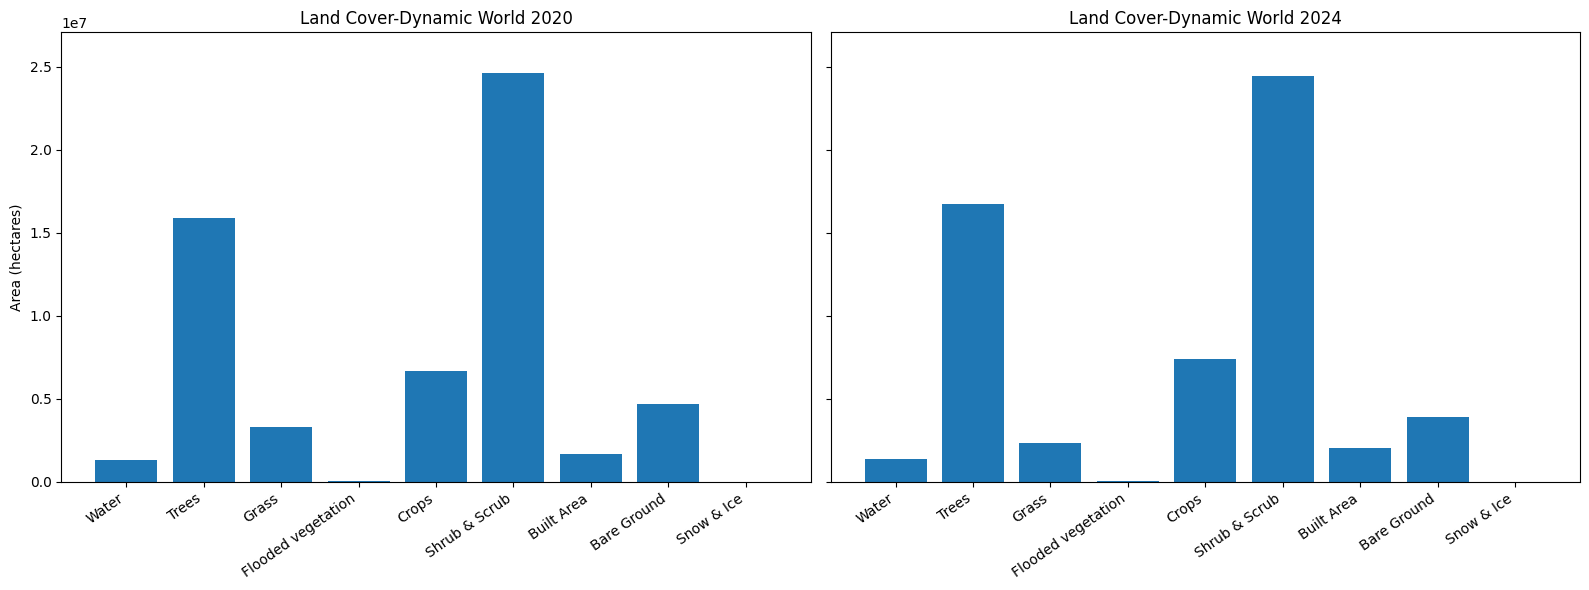

In [8]:


def side_by_side_area_plot(series_a, series_b, year_a=2020, year_b=2024, title_prefix="Land Cover-Dynamic World"):
    classes = list(series_a.index)
    y_max = max(series_a.max(), series_b.max()) * 1.1

    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

    axes[0].bar(classes, series_a.values)
    axes[0].set_title(f"{title_prefix} {year_a}")
    axes[0].set_ylabel("Area (hectares)")
    axes[0].set_xticklabels(classes, rotation=35, ha='right')
    axes[0].set_ylim(0, y_max)

    axes[1].bar(classes, series_b.values)
    axes[1].set_title(f"{title_prefix} {year_b}")
    axes[1].set_xticklabels(classes, rotation=35, ha='right')
    axes[1].set_ylim(0, y_max)

    plt.tight_layout()
    plt.show()

side_by_side_area_plot(ha_2020, ha_2024, 2020, 2024)


In [9]:


def _ensure_label(img):
    b = ee.String(img.bandNames().get(0))
    return ee.Image(ee.Algorithms.If(b.equals('label'),
                                     img.select('label'),
                                     img.select(b).rename('label')))

def maps_2x2_panel(years=(2020, 2021, 2023, 2024), region=AOI, zoom=6,
                   palette=PALETTE, legend=LEGEND_DICT):
    """Build a 2×2 linked maps panel for the given years."""
    assert len(years) == 4, "Provide exactly 4 years."

    lon, lat = region.centroid().coordinates().getInfo()
    center = (lat, lon)

    # build four maps
    maps = [geemap.Map(center=center, zoom=zoom) for _ in years]
    outline = ee.FeatureCollection([ee.Feature(region)])

    for m, y in zip(maps, years):
        img = _ensure_label(ANNUAL[y]).clip(region)
        m.addLayer(img, {"min":0, "max":8, "palette": palette}, f"DW {y}")
        m.addLayer(outline, {"color":"black"}, "AOI")
        try:
            m.add_text(f"Kenya — {y}", font_size=14, position="topcenter")
        except Exception:
            pass
        m.add_legend(title=f"ESA Dynamic World {y}", legend_dict=legend)
        try:
            m.add_latlon_grid(interval=1, add_label=True, style={"opacity":0.25, "weight":1})
        except Exception:
            pass
        m.addLayerControl()

    # link pans/zooms
    try:
        geemap.link(*maps)
    except Exception:
        try:
            geemap.link(maps[0], maps[1]); geemap.link(maps[0], maps[2]); geemap.link(maps[0], maps[3])
        except Exception:
            pass

    # arrange 2×2
    top = widgets.HBox([maps[0], maps[1]], layout=widgets.Layout(justify_content="space-between"))
    bottom = widgets.HBox([maps[2], maps[3]], layout=widgets.Layout(justify_content="space-between"))
    panel = widgets.VBox([top, bottom])
    return panel


# Run it:
maps_2x2_panel((2020, 2021, 2023, 2024), AOI, zoom=ZOOM_LEVEL)


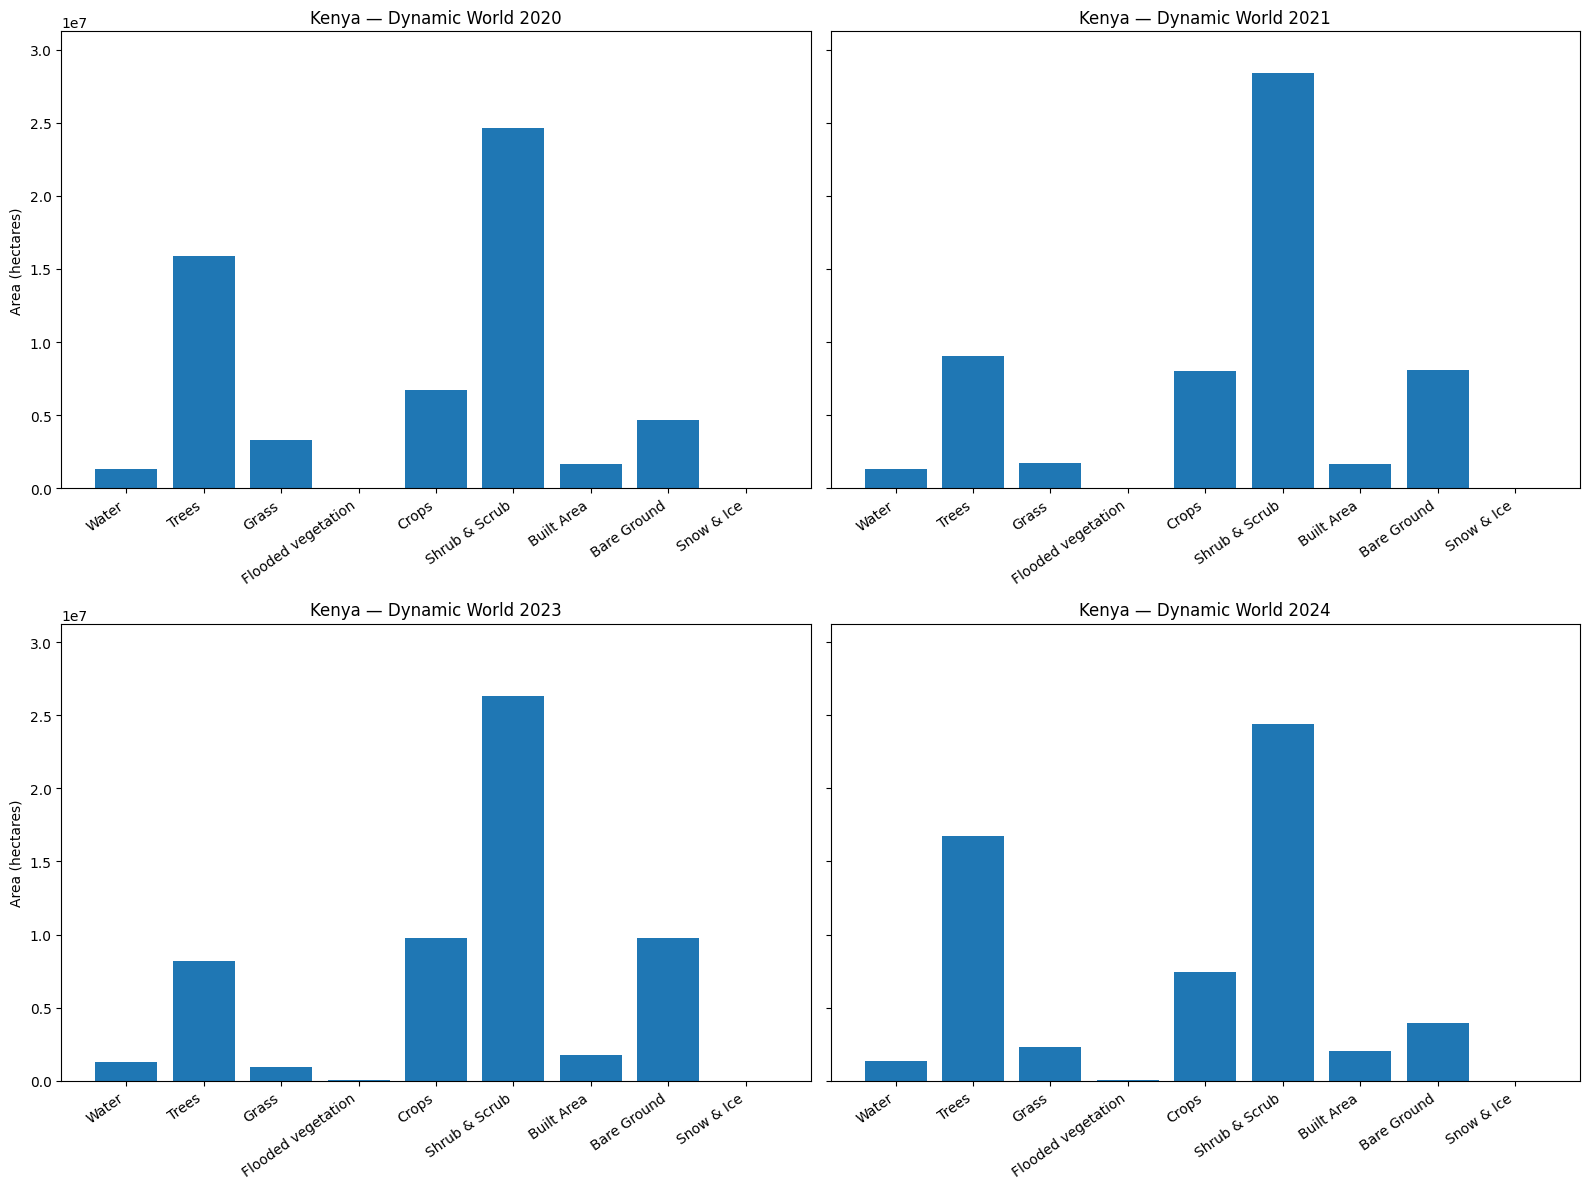

,2020,2021,2023,2024
Water,"1,332,539","1,293,069","1,289,763","1,369,062"
Trees,"15,885,920","9,015,843","8,171,395","16,745,007"
Grass,"3,277,028","1,721,511","968,190","2,308,071"
Flooded vegetation,"43,275","25,652","28,171","37,704"
Crops,"6,696,463","8,015,891","9,792,327","7,412,147"
Shrub & Scrub,"24,612,755","28,405,640","26,294,593","24,414,437"
Built Area,"1,682,293","1,680,827","1,775,712","2,018,393"
Bare Ground,"4,694,367","8,062,488","9,776,041","3,926,968"
Snow & Ice,"4,756",614,"12,651",734


In [10]:

def charts_2x2_panel(years=(2020, 2021, 2023, 2024),
                     region=AOI_SIMP, scale=80, tilescale=4,
                     title_prefix="Kenya — Dynamic World"):
    # Compute areas (ha) per year with the fast function
    series_list = []
    for y in years:
        s = area_by_class_hectares_fast(ANNUAL[y], region, scale=scale, tilescale=tilescale)
        series_list.append(s.rename(str(y)))

    # Shared y limit
    ymax = max(s.max() for s in series_list) * 1.1
    classes = list(series_list[0].index)

    fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharey=True)
    axes = axes.flatten()

    for ax, s, y in zip(axes, series_list, years):
        ax.bar(classes, s.values)
        ax.set_title(f"{title_prefix} {y}")
        ax.set_ylim(0, ymax)
        ax.set_xticklabels(classes, rotation=35, ha='right')
        if ax in (axes[0], axes[2]):
            ax.set_ylabel("Area (hectares)")

    plt.tight_layout()
    plt.show()

    # Also return a combined comparison table
    df = pd.concat(series_list, axis=1)
    return df

# Run it:
df_2x2 = charts_2x2_panel((2020, 2021, 2023, 2024))
display(df_2x2.style.format("{:,.0f}"))

# save the comparison as CSV
# df_2x2.to_csv("kenya_dw_area_ha_2020_2021_2023_2024.csv", float_format="%.0f")
# print("Saved: kenya_dw_area_ha_2020_2021_2023_2024.csv")
